In [2]:
!pip install datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 474.6/474.6 kB 11.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 16.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 48.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 27.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 13.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 21.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 25.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 15.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.6/149.6 kB 16.5 MB/s eta 0:00:00


In [3]:
from __future__ import annotations
import pickle, gzip, math, os, time, shutil, torch, matplotlib as mpl, numpy as np, matplotlib.pyplot as plt
from pathlib import Path
from operator import itemgetter
from itertools import zip_longest
import fastcore.all as fc

import torch
from torch.utils.data import DataLoader, default_collate
import torch.nn.functional as F

from datasets import load_dataset, load_dataset_builder

In [4]:
import torchvision.transforms.functional as TF
from fastcore.test import test

torch.set_printoptions(precision=2, linewidth=140, sci_mode=False)
torch.manual_seed(1)
mpl.rcParams['image.cmap'] = 'gray_r'

# Hugging Face Datasets

In [5]:
name = 'fashion_mnist'
ds_builder = load_dataset_builder(name)
print(ds_builder.info.description)

Fashion-MNIST is a dataset of Zalando's article images—consisting of a training set of
60,000 examples and a test set of 10,000 examples. Each example is a 28x28 grayscale image,
associated with a label from 10 classes. We intend Fashion-MNIST to serve as a direct drop-in
replacement for the original MNIST dataset for benchmarking machine learning algorithms.
It shares the same image size and structure of training and testing splits.



In [6]:
ds_builder.info.features

{'image': Image(decode=True, id=None),
 'label': ClassLabel(names=['T - shirt / top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'], id=None)}

In [7]:
ds_builder.info.splits

{'train': SplitInfo(name='train', num_bytes=31296655, num_examples=60000, shard_lengths=None, dataset_name=None),
 'test': SplitInfo(name='test', num_bytes=5233818, num_examples=10000, shard_lengths=None, dataset_name=None)}

In [8]:
dsd = load_dataset(name)
dsd

Extracting data files:   0%|          | 0/4 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/60000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

Dataset fashion_mnist downloaded and prepared to /root/.cache/huggingface/datasets/fashion_mnist/fashion_mnist/1.0.0/0a671f063342996f19779d38c0ab4abef9c64f757b35af8134b331c294d7ba48. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 60000
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 10000
    })
})

In [9]:
train, test = dsd['train'], dsd['test']
train[0]

{'image': <PIL.PngImagePlugin.PngImageFile image mode=L size=28x28 at 0x7F43EC4AB4F0>,
 'label': 9}

In [10]:
x, y = 'image', 'label'
img = train[0][x]
img

In [11]:
x, y = ds_builder.info.features
x, y

('image', 'label')

In [12]:
xb = train[:5][x]
yb = train[:5][y]
yb

[9, 0, 0, 3, 0]

In [13]:
featy = train.features[y]
featy

ClassLabel(names=['T - shirt / top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'], id=None)

In [14]:
featy.int2str(yb)

['Ankle boot',
 'T - shirt / top',
 'T - shirt / top',
 'Dress',
 'T - shirt / top']

In [15]:
train['label'][:5]

[9, 0, 0, 3, 0]

In [16]:
def collate_fn(b):
  return {x: torch.stack([TF.to_tensor(o[x]) for o in b]),
          y: torch.tensor([o[y] for o in b])
          }

In [17]:
dl = DataLoader(train, collate_fn=collate_fn, batch_size=16)
b = next(iter(dl))
b[x].shape, b[y]

(torch.Size([16, 1, 28, 28]),
 tensor([9, 0, 0, 3, 0, 2, 7, 2, 5, 5, 0, 9, 5, 5, 7, 9]))

In [18]:
def transforms(b):
  b[x] = [TF.to_tensor(o) for o in b[x]]
  return b

In [19]:
tds = train.with_transform(transforms)
dl = DataLoader(tds, batch_size=16)
b = next(iter(dl))
b[x].shape, b[y]

(torch.Size([16, 1, 28, 28]),
 tensor([9, 0, 0, 3, 0, 2, 7, 2, 5, 5, 0, 9, 5, 5, 7, 9]))

In [20]:
def _transformi(b):
  b[x] = [torch.flatten(TF.to_tensor(o)) for o in b[x]]

In [21]:
def inplace(f):
  def _f(b):
    f(b)
    return b
  return _f

In [22]:
transformi = inplace(_transformi)

In [23]:
r = train.with_transform(transformi)[0]
r[x].shape, r[y]

(torch.Size([784]), 9)

In [24]:
@inplace
def transformi(b):
  b[x] = [torch.flatten(TF.to_tensor(o)) for o in b[x]]

In [25]:
tdsf = train.with_transform(transformi)
r = tdsf[0]
r[x].shape, r[y]

(torch.Size([784]), 9)

In [26]:
class D:
  def __getitem__(self, k):
    return 1 if k=='a' else 2 if k == 'b' else 3

In [27]:
ig = itemgetter('a', 'c')
d = D()
ig(d)

(1, 3)

In [28]:
list(tdsf.features)

['image', 'label']

In [29]:
def collate_dict(ds):
  get = itemgetter(*ds.features)
  def _f(b):
    return get(default_collate(b))
  return _f

In [30]:
dlf = DataLoader(tdsf, batch_size=4, collate_fn=collate_dict(tdsf))
xb, yb = next(iter(dlf))
xb.shape, yb

(torch.Size([4, 784]), tensor([9, 0, 0, 3]))

In [31]:
@fc.delegates(plt.Axes.imshow)
def show_image(im, ax=None, figsize=None, title=None, **kwargs):
  "Show a PIL or PyTorch image on 'ax'."
  if fc.hasattrs(im, ('cpu', 'premute')):
    im = im.cpu()
    if im.shape[0]<5:
      im = im.permute(1,2,0)
  elif not isinstance(im, np.ndarray):
    im = np.array(im)
  
  if im.shape[-1] == 1:
    im=im[...,0]
  
  if ax is None:
    _,ax = plt.subplots(figsize=figsize)
  ax.imshow(im, **kwargs)
  if title is not None:
    ax.set_title(title)
  ax.axis('off')
  return ax
    
    


In [32]:
help(show_image)

Help on function show_image in module __main__:

show_image(im, ax=None, figsize=None, title=None, *, cmap=None, norm=None, aspect=None, interpolation=None, alpha=None, vmin=None, vmax=None, origin=None, extent=None, interpolation_stage=None, filternorm=True, filterrad=4.0, resample=None, url=None, data=None)
    Show a PIL or PyTorch image on 'ax'.



<Axes: >

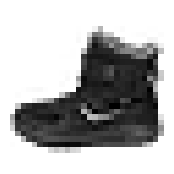

In [33]:
show_image(img, figsize=(2,2))

In [34]:
#|export
@fc.delegates(plt.subplots, keep=True)
def subplots(
    nrows:int=1, # Number of rows in returned axes grid
    ncols:int=1, # Number of columns in returned axes grid
    figsize:tuple=None, # Width, height in inches of the returned figure
    imsize:int=3, # Size (in inches) of images that will be displayed in the returned figure
    suptitle:str=None, # Title to be set to returned figure
    **kwargs
): # fig and axs
    "A figure and set of subplots to display images of `imsize` inches"
    if figsize is None: figsize=(ncols*imsize, nrows*imsize)
    fig,ax = plt.subplots(nrows, ncols, figsize=figsize, **kwargs)
    if suptitle is not None: fig.suptitle(suptitle)
    if nrows*ncols==1: ax = np.array([ax])
    return fig,ax


TypeError: ignored

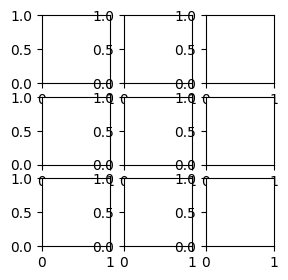

In [41]:
fig, axs = subplots(3,3,imsize=1)
imgs = xb[:8]
for ax, img in zip(axs.flat, imgs):
  show_image(img, ax)